In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matlplotlib inline
import os
import math
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix

UsageError: Line magic function `%matlplotlib` not found.


In [14]:
import tensorflow
tensorflow.__version__
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from PIL import Image

In [3]:
path=r'C:\Users\manit\Desktop\Tp_Project\Dataset'
print(os.listdir(path))
data=pd.read_csv(path+'\\icml_face_data.csv')
train=pd.read_csv(path+'\\train.csv')
test=pd.read_csv(path+'\\test.csv')


['example_submission.csv', 'fer2013', 'fer2013.tar.gz', 'icml_face_data.csv', 'test.csv', 'train.csv']


In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
img = cv2.imread('Test.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.1, 4)
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    faces = img[y:y + h, x:x + w]
    cv2.imshow("face",faces)
    # cv2.imwrite('face.jpg', faces)
# cv2.imwrite('detcted.jpg', img)
cv2.imshow('img', img)
k = cv2.waitKey(0)
if k == 27:         
    cv2.destroyAllWindows()
elif k == ord('s'):
    cv2.imwrite('messigray.png',img)
    cv2.destroyAllWindows()


In [4]:
print(data.columns)
print(data.head())
print(test.head())
print(train.head())

Index(['emotion', ' Usage', ' pixels'], dtype='object')
   emotion     Usage                                             pixels
0        0  Training  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  Training  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  Training  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  Training  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  Training  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                                              pixels
0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1  156 184 198 202 204 207 210 212 213 214 215 21...
2  69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3  205 203 236 157 83 158 120 116 94 86 155 180 2...
4  87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...
   emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2       

In [5]:
data.columns = ['emotion', 'Usage', 'pixels']   
data['Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [7]:
len(data['pixels'][0].split())

2304

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   Usage    35887 non-null  object
 2   pixels   35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [7]:
data.describe()

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [8]:
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48, 1))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48)) 
        image_array[i, :, :, 0] = image / 255

    return image_array, image_label

def vis_training(hlist, start=1):
    
    loss = np.concatenate([h.history['loss'] for h in hlist])
    val_loss = np.concatenate([h.history['val_loss'] for h in hlist])
    acc = np.concatenate([h.history['accuracy'] for h in hlist])
    val_acc = np.concatenate([h.history['val_accuracy'] for h in hlist])
    
    epoch_range = range(1,len(loss)+1)

    plt.figure(figsize=[12,6])
    plt.subplot(1,2,1)
    plt.plot(epoch_range[start-1:], loss[start-1:], label='Training Loss')
    plt.plot(epoch_range[start-1:], val_loss[start-1:], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epoch_range[start-1:], acc[start-1:], label='Training Accuracy')
    plt.plot(epoch_range[start-1:], val_acc[start-1:], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

In [9]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [10]:
full_train_images, full_train_labels = prepare_data(data[data['Usage']=='Training'])
test_images, test_labels = prepare_data(data[data['Usage']!='Training'])

print(full_train_images.shape)
print(full_train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(28709, 48, 48, 1)
(28709,)
(7178, 48, 48, 1)
(7178,)


In [11]:
print(type(test_images))
# print(test_images[4].shape)
# print(test_images[4])
# plt.imshow(test_images[11])

<class 'numpy.ndarray'>


In [12]:
train_images, valid_images, train_labels, valid_labels =train_test_split(full_train_images, full_train_labels,test_size=0.2, random_state=1)

print(train_images.shape)
print(valid_images.shape)
print(train_labels.shape)
print(valid_labels.shape)

(22967, 48, 48, 1)
(5742, 48, 48, 1)
(22967,)
(5742,)


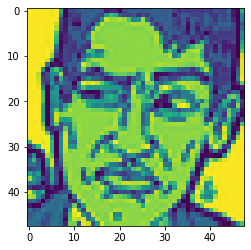

In [21]:
plt.imshow(test_images[0])

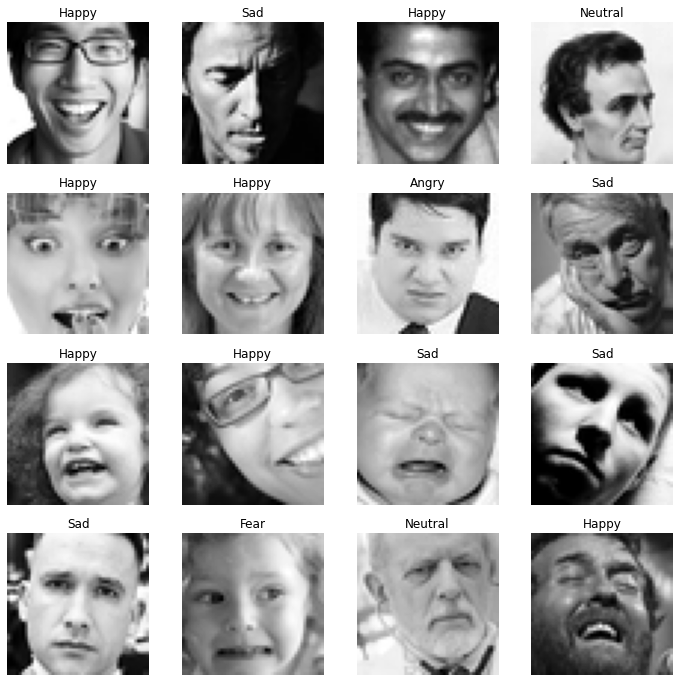

In [13]:
N_train = train_labels.shape[0]

sel = np.random.choice(range(N_train), replace=False, size=16)

X_sel = train_images[sel, :, :, :]
y_sel = train_labels[sel]

plt.figure(figsize=[12,12])
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(X_sel[i,:,:,0], cmap='binary_r')
    plt.title(emotions[y_sel[i]])
    plt.axis('off')
plt.show()

In [13]:
%%time 

cnn = keras.models.Sequential()

cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(48,48,1)))
cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn.add(Dropout(0.25))
cnn.add(BatchNormalization())

cnn.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn.add(Dropout(0.25))
cnn.add(BatchNormalization())

cnn.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn.add(Dropout(0.5))
cnn.add(BatchNormalization())

cnn.add(Flatten())

cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.5))

cnn.add(Dense(7, activation='softmax'))

cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 256)       5